In [2]:
import torch
import numpy as np

In [3]:
torch.cuda.is_available()

True

### Define Transforms

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms

These are the current "best practice" transforms for train and test time respectively according to the paper.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [7]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

### Load Imagenette2

In [8]:
train_path = "/storage/data/imagenette2/train"

In [9]:
train_data = datasets.ImageFolder(train_path, 
                                 transform=train_transform 
                                 )

In [10]:
test_path = '/storage/data/imagenette2/val'

In [11]:
test_data = datasets.ImageFolder(test_path,
                                transform=test_transform
                                )

In [12]:
from torch.utils.data.sampler import SubsetRandomSampler
# I don't want to train on all the data just yet
indices = list(range(len(train_data)))
np.random.shuffle(indices)
subset_indices = 1000
train_sampler=SubsetRandomSampler(indices[:subset_indices])

In [13]:
len(train_sampler)

1000

In [14]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=train_sampler)

In [15]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Visualize a Batch of Training Data

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

#helper function to un-normalize and display an image
def imshow(img):
    img = img/2+0.5 #unnormalize
    plt.imshow(np.transpose(img,(1,2,0))) # convert from Tensor image

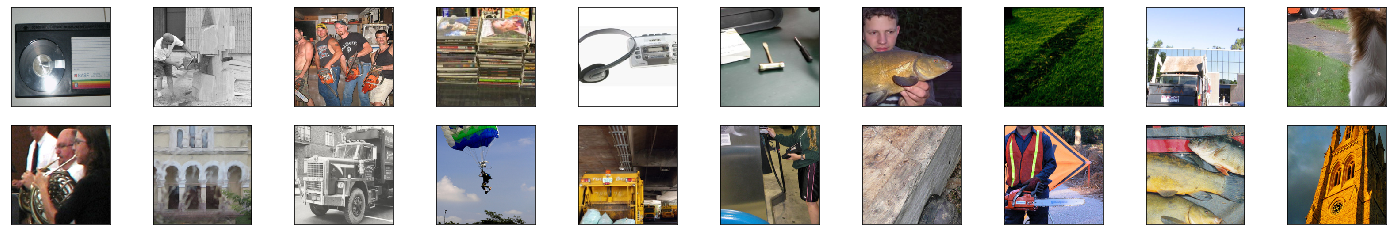

In [17]:
######################
##for batch size 20 ##
######################


#obtain one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

#plot the images in the batch
fig = plt.figure(figsize=(25,4))
#display 20 images
for idx in np.arange(20):
    ax= fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

### RandomResizedCrop

In [18]:
from os import listdir
from PIL import Image as PImage

def loadImages(path):
    # return array of images

    imagesList = listdir(path)
    imagesList.sort()
    loadedImages = []
    for i, image in enumerate(imagesList):
        if i==20: return loadedImages
        img = PImage.open(path + image)
        loadedImages.append(img)

    return loadedImages

path = "/storage/data/imagenette2/train/n01440764/"

# your images in an array
imgs = loadImages(path)

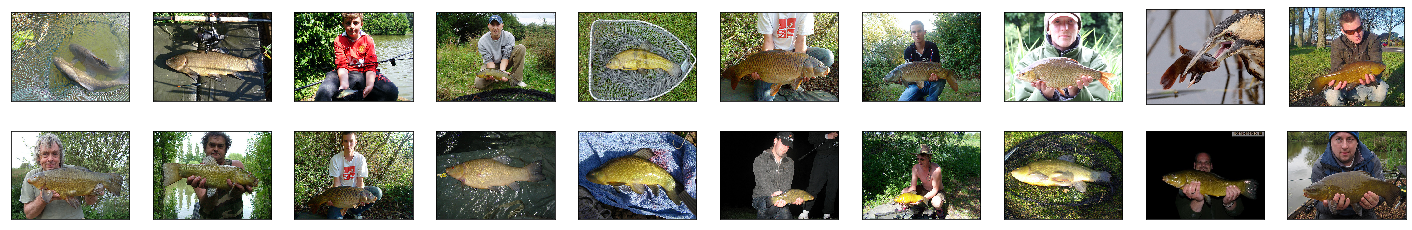

In [19]:
#plot the images in the batch
fig = plt.figure(figsize=(25,4))
#display 20 images
for idx in np.arange(20):
    ax= fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = np.asarray(imgs[idx])
    ax.imshow(img)
    

These are the untransformed original images

### Resize>CenterCrop vs CenterCrop

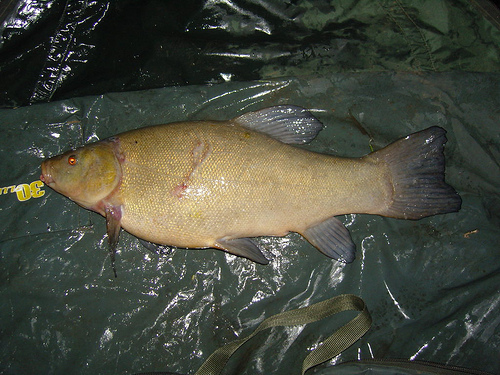

In [20]:
img = PImage.open("/storage/data/imagenette2/train/n01440764/ILSVRC2012_val_00016018.JPEG")
img

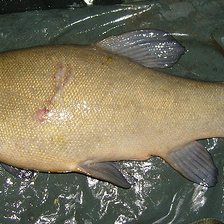

In [21]:
#CenterCrop
transforms.CenterCrop(224)(img)

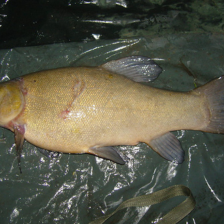

In [22]:
#Resize>CenterCrop
transform = transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224)])
transform(img)

### Does transforms.RandomResizedCrop match the supposed descriptions in the paper?

In [23]:
transforms.RandomResizedCrop(224)

RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)

A crop of random size (default: of 0.08 to 1.0) of the original size and a random \
aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. This crop \
is finally resized to given size.

```
target_area = random.uniform(*scale) * area
log_ratio = (math.log(ratio[0]), math.log(ratio[1]))
aspect_ratio = math.exp(random.uniform(*log_ratio))
```

This code is pulled from the documentation for torchvision.transforms.transforms. \
For math.log() with one argument, return the natural logarithm of x (to base e).

Answer: Yes. Except in the paper, they pulled a squared ratio from a uniform distribution with squared upper and lower bounds.

### Increase k<sub>imagetest</sub>: Fix k<sub>test</sub>  vs Fix $\frac{k_{image test}}{k_{test}}$

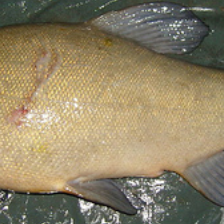

In [24]:
#Fix k_test
#Resize>CenterCrop
transform = transforms.Compose([transforms.Resize(500), 
                               transforms.CenterCrop(224)])
transform(img)

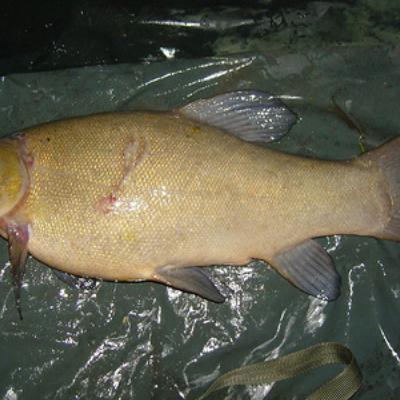

In [25]:
#Fix k_imagetest/k_test
transform = transforms.Compose([transforms.Resize(500), 
                               transforms.CenterCrop(400)])
transform(img)

Indeed if you only increase k_imagetest, and fix k_test then you'll only be looking at a smaller part of the object. \
But if you fix k_imagetest/k_test, then you can see the whole object.

# train-test: Does apparent size match?

##### train:

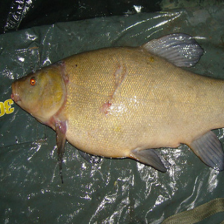

In [26]:
transform = transforms.RandomResizedCrop(224)
transform(img)

##### test w/ no k<sub>imagetest</sub> i.e no Resize before CenterCrop

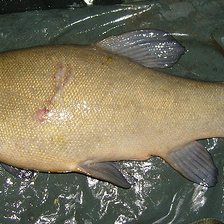

In [27]:
transform = transforms.CenterCrop(224)
transform(img)

##### test w/o increased k<sub>imagetest</sub>

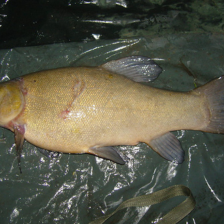

In [28]:
transform = transforms.Compose([transforms.Resize(256), 
                               transforms.CenterCrop(224)])
transform(img)

##### test w/ increased k<sub>imagetest</sub>

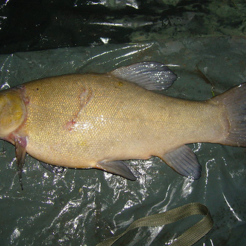

In [29]:
transform = transforms.Compose([transforms.Resize(280), 
                               transforms.CenterCrop(246)])
transform(img)

# test DA vs train DA

### Baseline

In [30]:
import torchvision.models as models
import torch.nn as nn

In [31]:
model = models.resnet18()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
import torch.optim as optim

In [33]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [34]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    
    train_loss = 0.0
    print(epoch)
    model.train()
    for data, target in trainloader:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0) #KIV
    
    # calculate average loss
    train_loss = train_loss/len(trainloader.sampler)
    
    # print feedback
    print('Epoch: {:.6f} \tTraining Loss: {:.6f}'.format(epoch,
                                                    train_loss
    ))

1
Epoch: 1.000000 	Training Loss: 4.780998
2
Epoch: 2.000000 	Training Loss: 2.632511
3
Epoch: 3.000000 	Training Loss: 2.282005
4
Epoch: 4.000000 	Training Loss: 2.141451
5
Epoch: 5.000000 	Training Loss: 2.089429
6
Epoch: 6.000000 	Training Loss: 2.051903
7
Epoch: 7.000000 	Training Loss: 1.980092
8
Epoch: 8.000000 	Training Loss: 1.980422
9
Epoch: 9.000000 	Training Loss: 1.920392
10
Epoch: 10.000000 	Training Loss: 1.898126
11
Epoch: 11.000000 	Training Loss: 1.873738
12
Epoch: 12.000000 	Training Loss: 1.820808
13
Epoch: 13.000000 	Training Loss: 1.781184
14
Epoch: 14.000000 	Training Loss: 1.792214
15
Epoch: 15.000000 	Training Loss: 1.716822
16
Epoch: 16.000000 	Training Loss: 1.705184
17
Epoch: 17.000000 	Training Loss: 1.711757
18
Epoch: 18.000000 	Training Loss: 1.658830
19
Epoch: 19.000000 	Training Loss: 1.629762
20
Epoch: 20.000000 	Training Loss: 1.628891
21
Epoch: 21.000000 	Training Loss: 1.606576
22
Epoch: 22.000000 	Training Loss: 1.521877
23
Epoch: 23.000000 	Trainin

In [35]:
torch.save(model.state_dict(), 'model_baseline.pt')

### Test

In [36]:
model.load_state_dict(torch.load('model_baseline.pt'))

<All keys matched successfully>

In [37]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [38]:
model.eval()
# iterate over test data
for data, target in testloader:
    data, target = data.cuda(), target.cuda()
    output = model(data)
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate top 1 accuracy
    batch_size = len(target)
    for i in range(batch_size): #batch size
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('\n Test Accuracy (Overall): %2d%% (%2d/%2d)' %(
100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))


 Test Accuracy (Overall): 48% (1911/3925)


### fine tuning w/ train DA 

In [39]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
# layers to train
model.layer4[1].bn2
model.avgpool
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [41]:
for parameter in model.parameters():
    parameter.requires_grad = False

In [42]:
for parameter in model.layer4[1].bn2.parameters():
    parameter.requires_grad = True
for parameter in model.avgpool.parameters():
    parameter.requires_grad = True
for parameter in model.fc.parameters():
    parameter.requires_grad = True

In [43]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [44]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    
    train_loss = 0.0
    print(epoch)
    model.train()
    for data, target in trainloader:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0) #KIV
    
    # calculate average loss
    train_loss = train_loss/len(trainloader.sampler)
    
    # print feedback
    print('Epoch: {:.6f} \tTraining Loss: {:.6f}'.format(epoch,
                                                    train_loss
    ))

1
Epoch: 1.000000 	Training Loss: 1.343506
2
Epoch: 2.000000 	Training Loss: 1.373657
3
Epoch: 3.000000 	Training Loss: 1.349618
4
Epoch: 4.000000 	Training Loss: 1.353224
5
Epoch: 5.000000 	Training Loss: 1.374830
6
Epoch: 6.000000 	Training Loss: 1.368095
7
Epoch: 7.000000 	Training Loss: 1.312094
8
Epoch: 8.000000 	Training Loss: 1.352655
9
Epoch: 9.000000 	Training Loss: 1.363059
10
Epoch: 10.000000 	Training Loss: 1.349289
11
Epoch: 11.000000 	Training Loss: 1.302988
12
Epoch: 12.000000 	Training Loss: 1.319093
13
Epoch: 13.000000 	Training Loss: 1.359222
14
Epoch: 14.000000 	Training Loss: 1.320005
15
Epoch: 15.000000 	Training Loss: 1.323885
16
Epoch: 16.000000 	Training Loss: 1.343036
17
Epoch: 17.000000 	Training Loss: 1.347325
18
Epoch: 18.000000 	Training Loss: 1.370868
19
Epoch: 19.000000 	Training Loss: 1.328821
20
Epoch: 20.000000 	Training Loss: 1.316790
21
Epoch: 21.000000 	Training Loss: 1.354138
22
Epoch: 22.000000 	Training Loss: 1.324226
23
Epoch: 23.000000 	Trainin

In [45]:
torch.save(model.state_dict(), 'model_train_da.pt')

### Test

In [46]:
model.load_state_dict(torch.load('model_train_da.pt'))

<All keys matched successfully>

In [47]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [48]:
model.eval()
# iterate over test data
for data, target in testloader:
    data, target = data.cuda(), target.cuda()
    output = model(data)
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate top 1 accuracy
    batch_size = len(target)
    for i in range(batch_size): #batch size
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('\n Test Accuracy (Overall): %2d%% (%2d/%2d)' %(
100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))


 Test Accuracy (Overall): 55% (2161/3925)


3% increase with fine tuning

### fine tuning w/ test DA 

In [49]:
model.load_state_dict(torch.load('model_baseline.pt'))

<All keys matched successfully>

In [50]:
train_data = datasets.ImageFolder(train_path, 
                                 transform=test_transform # test DA
                                 )

trainloader_testDA = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=train_sampler)

In [51]:
for parameter in model.parameters():
    parameter.requires_grad = False

In [52]:
for parameter in model.layer4[1].bn2.parameters():
    parameter.requires_grad = True
for parameter in model.avgpool.parameters():
    parameter.requires_grad = True
for parameter in model.fc.parameters():
    parameter.requires_grad = True

In [53]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [54]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    
    train_loss = 0.0
    print(epoch)
    model.train()
    for data, target in trainloader_testDA:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0) #KIV
    
    # calculate average loss
    train_loss = train_loss/len(trainloader_testDA.sampler)
    
    # print feedback
    print('Epoch: {:.6f} \tTraining Loss: {:.6f}'.format(epoch,
                                                    train_loss
    ))

1
Epoch: 1.000000 	Training Loss: 1.151144
2
Epoch: 2.000000 	Training Loss: 1.164363
3
Epoch: 3.000000 	Training Loss: 1.136046
4
Epoch: 4.000000 	Training Loss: 1.145616
5
Epoch: 5.000000 	Training Loss: 1.139862
6
Epoch: 6.000000 	Training Loss: 1.138525
7
Epoch: 7.000000 	Training Loss: 1.133460
8
Epoch: 8.000000 	Training Loss: 1.136754
9
Epoch: 9.000000 	Training Loss: 1.139230
10
Epoch: 10.000000 	Training Loss: 1.135353
11
Epoch: 11.000000 	Training Loss: 1.129820
12
Epoch: 12.000000 	Training Loss: 1.138355
13
Epoch: 13.000000 	Training Loss: 1.132465
14
Epoch: 14.000000 	Training Loss: 1.139986
15
Epoch: 15.000000 	Training Loss: 1.140571
16
Epoch: 16.000000 	Training Loss: 1.125695
17
Epoch: 17.000000 	Training Loss: 1.131410
18
Epoch: 18.000000 	Training Loss: 1.137836
19
Epoch: 19.000000 	Training Loss: 1.118169
20
Epoch: 20.000000 	Training Loss: 1.122467
21
Epoch: 21.000000 	Training Loss: 1.122883
22
Epoch: 22.000000 	Training Loss: 1.127054
23
Epoch: 23.000000 	Trainin

In [55]:
torch.save(model.state_dict(), 'model_test_da.pt')

### Test

In [56]:
model.load_state_dict(torch.load('model_test_da.pt'))

<All keys matched successfully>

In [57]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [58]:
model.eval()
# iterate over test data
for data, target in testloader:
    data, target = data.cuda(), target.cuda()
    output = model(data)
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate top 1 accuracy
    batch_size = len(target)
    for i in range(batch_size): #batch size
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('\n Test Accuracy (Overall): %2d%% (%2d/%2d)' %(
100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))


 Test Accuracy (Overall): 55% (2175/3925)


No improvement

### Use higher test time res

In [64]:
test_transform_hres = transforms.Compose([
    transforms.Resize(280),
    transforms.CenterCrop(246),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [65]:
test_data_hres = datasets.ImageFolder(test_path,
                                transform=test_transform_hres
                                )

In [66]:
testloader_hres = torch.utils.data.DataLoader(test_data_hres, batch_size=64)

### Test

In [67]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [68]:
model.eval()
# iterate over test data
for data, target in testloader_hres:
    data, target = data.cuda(), target.cuda()
    output = model(data)
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate top 1 accuracy
    batch_size = len(target)
    for i in range(batch_size): #batch size
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('\n Test Accuracy (Overall): %2d%% (%2d/%2d)' %(
100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))


 Test Accuracy (Overall): 54% (2155/3925)


### Use even higher test time res

In [70]:
test_transform_hres = transforms.Compose([
    transforms.Resize(342),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [71]:
test_data_hres = datasets.ImageFolder(test_path,
                                transform=test_transform_hres
                                )

In [72]:
testloader_hres = torch.utils.data.DataLoader(test_data_hres, batch_size=64)

### Test

In [73]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [74]:
model.eval()
# iterate over test data
for data, target in testloader_hres:
    data, target = data.cuda(), target.cuda()
    output = model(data)
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate top 1 accuracy
    batch_size = len(target)
    for i in range(batch_size): #batch size
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('\n Test Accuracy (Overall): %2d%% (%2d/%2d)' %(
100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))


 Test Accuracy (Overall): 54% (2145/3925)
